# This notebook reproduces Figure 5 from the paper

# Load dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision

# All hyperparameters:
dataset = 'fashion_mnist' # or 'cifar10'
number_of_samples = 5000
number_of_steps = 5000
steps = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # recommend [0.001, 1.0, 100.0] to speed up

_path_to_dataset = './'

if dataset == 'cifar10':
    filter_classes = [0, 1]
    transform_train = [transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    transform_train = transforms.Compose(transform_train)
    trainset = torchvision.datasets.CIFAR10(root=_path_to_dataset, train=True, download=True,
                                            transform=transform_train)
elif dataset == 'fashion_mnist':
    filter_classes = [0, 4]
    transform_train = [transforms.ToTensor(),
                       transforms.Normalize((0.5), (1.0))]
    transform_train = transforms.Compose(transform_train)
    trainset = torchvision.datasets.FashionMNIST(root=_path_to_dataset, train=True, download=True,
                                                 transform=transform_train)
else:
    assert False


In [ ]:
import numpy as np

features = [feature for feature, _ in trainset]
features = torch.stack(features)
features = features.reshape(features.shape[0], -1)
labels = torch.LongTensor([label for _, label in trainset])

In [ ]:
print("Features Shape: ", features.shape)

Features Shape:  torch.Size([60000, 784])


# Subsample classes

In [ ]:
features_subsample = None
labels_subsample = None
assert len(filter_classes) == 2
for filter_class in filter_classes:
    indices = np.where(labels == filter_class)[0]
    if features_subsample is None:
        features_subsample = features[indices, :]
        labels_subsample = torch.zeros((len(indices), ), dtype=torch.long)
    else:
        features_subsample = torch.concat((features_subsample,
                                           features[indices, :]))
        labels_subsample = torch.concat((labels_subsample,
                                         torch.ones((len(indices), ), dtype=torch.long)))
print("Features Shape: ", features_subsample.shape, " Labels Shape: ", labels_subsample.shape)

Features Shape:  torch.Size([12000, 784])  Labels Shape:  torch.Size([12000])


# Subsample data

In [ ]:
assert number_of_samples <= len(labels_subsample)
random_indices = torch.randperm(len(labels_subsample))[:number_of_samples]
features_subsample = features_subsample[random_indices, :]
labels_subsample = labels_subsample[random_indices]
print("Features Shape: ", features_subsample.shape, " Labels Shape: ", labels_subsample.shape)

Features Shape:  torch.Size([5000, 784])  Labels Shape:  torch.Size([5000])


# Run Logistic Regression with Gradient Descent

In [ ]:
import torch.nn as nn

model_init = nn.Sequential(nn.Flatten(), nn.LazyLinear(1, bias=False))
data_init = model_init[1].weight.data

step_size_to_plots = {}
for step_size in steps:
    model = nn.Sequential(nn.Flatten(), nn.LazyLinear(1, bias=False))
    model[1].weight.data = torch.clone(data_init)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    labels_subsample_float = labels_subsample.float()
    losses = []
    accuracies = []
    for _ in range(number_of_steps):
        output = model(features_subsample)
        output = torch.squeeze(output)
        loss = loss_fn(output, labels_subsample_float)
        losses.append(float(loss.detach()))
        correct = (output >= 0) == labels_subsample
        accuracies.append(float(torch.mean(correct.float())))
        model.zero_grad()
        loss.backward()
        model[1].weight.data = model[1].weight.data - step_size * model[1].weight.grad.data
    step_size_to_plots[step_size] = [losses, accuracies]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Plot Results

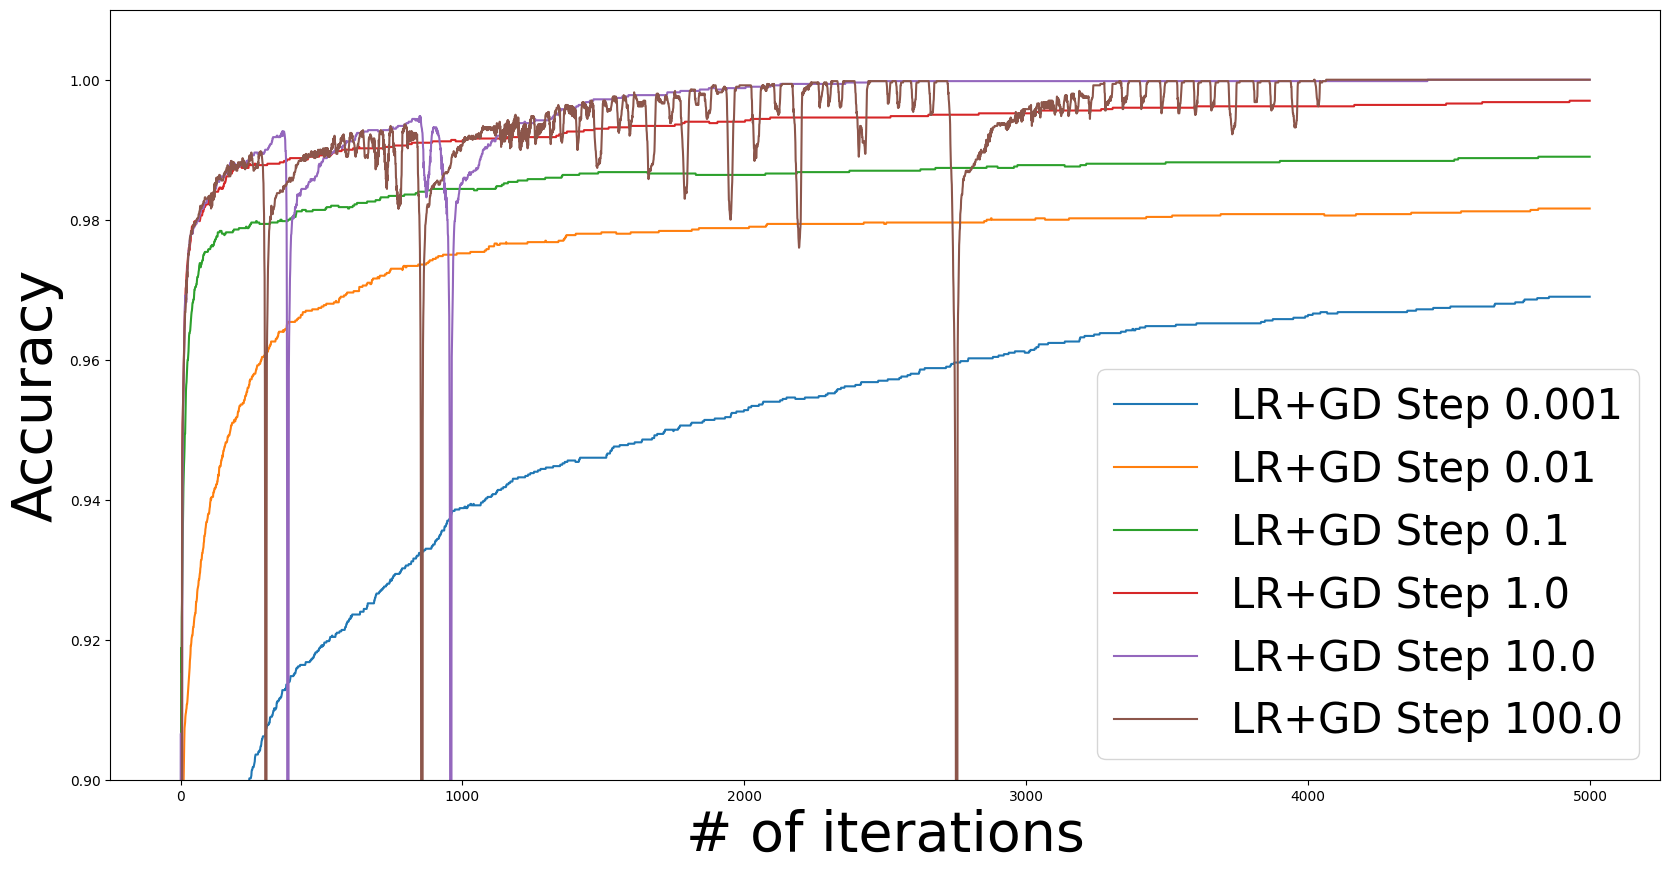

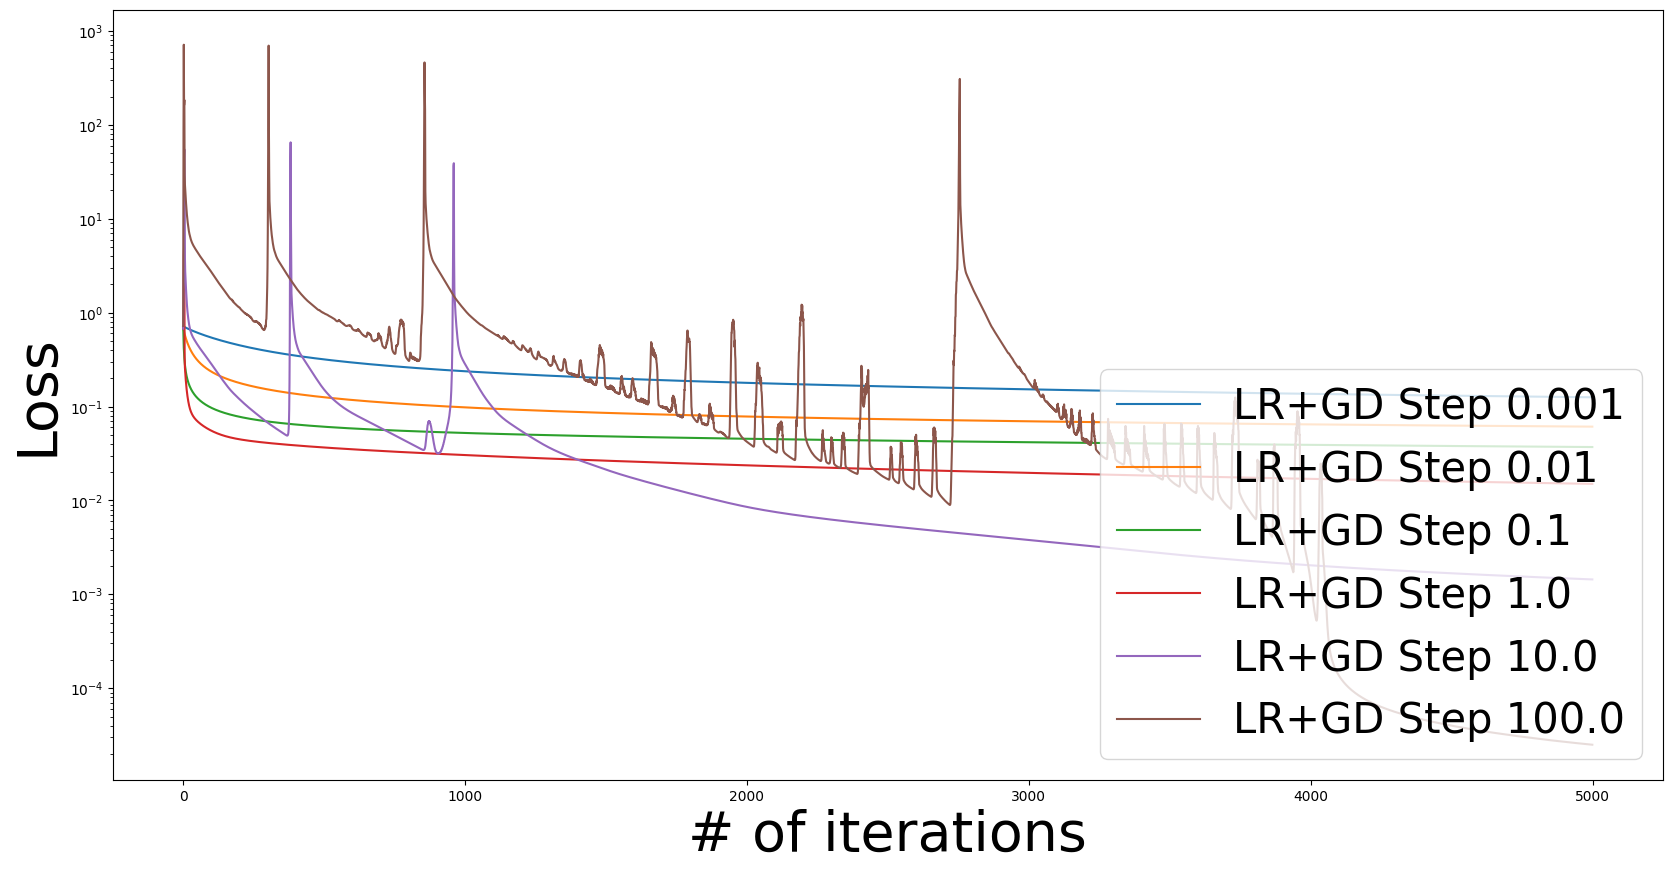

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
for step_size in step_size_to_plots:
    _, accuracies = step_size_to_plots[step_size]
    line, = ax.plot(accuracies, label=f'LR+GD Step {step_size}')
ax.set_ylabel('Accuracy', size=40)
ax.set_xlabel('# of iterations', size=40)
ax.legend(fontsize=30, loc='lower right')
ax.set_ylim([0.9, 1.01])

fig, ax = plt.subplots(figsize=(20, 10))
for step_size in step_size_to_plots:
    losses, _ = step_size_to_plots[step_size]
    line, = ax.plot(losses, label=f'LR+GD Step {step_size}')
ax.set_ylabel('Loss', size=40)
ax.set_xlabel('# of iterations', size=40)
ax.set_yscale('log')
ax.legend(fontsize=30, loc='lower right')